# investigating sync issue in SDK issue 1926
Given the high value of this session (and its 6 associated passing mesoscope planes), this is worth some deeper investigation.  
Also, we should understand to avoid allowing this to happen again!!!

In [1]:
from visual_behavior import database as db
import visual_behavior.utilities as vbu
from allensdk.brain_observatory.behavior.behavior_ophys_session import BehaviorOphysSession
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

from visual_behavior.translator.foraging2 import data_to_change_detection_core
import visual_behavior.ophys.sync.sync_dataset as sync_dataset

/allen/programs/braintv/workgroups/nc-ophys/Doug/code/AllenSDK/allensdk/brain_observatory/session_api_utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
%matplotlib notebook

## gather some files/data

In [4]:
ophys_session_id = 945124131

In [5]:
wkf = db.get_well_known_files(ophys_session_id)
wkf

,id,size,content_type,filename,created_at,updated_at,storage_directory,well_known_file_type_id,file_source_id,published_at,workflow_state,attachable_id,attachable_type,id,created_at,updated_at
name,,,,,,,,,,,,,,,,
EyeTracking Ellipses,992741641,19563880,application/x-hdf; charset=binary,945124131_ellipse.h5,2019-12-06 18:49:48.854147,2021-02-10 06:20:38.771592,/allen/programs/braintv/production/neuralcodin...,914623492,None,None,None,945124131,OphysSession,914623492,2019-07-31 13:22:05.683874,2019-07-31 13:22:05.683874
EyeDlcOutputFile,992741642,118612116,application/x-hdf; charset=binary,945124131_video-1DeepCut_resnet50_universal_ey...,2019-12-06 18:49:48.918166,2019-12-06 18:49:48.918166,/allen/programs/braintv/production/neuralcodin...,990460508,None,None,None,945124131,OphysSession,990460508,2019-11-26 16:47:20.006823,2019-11-26 16:47:20.006823
RawBehaviorTrackingVideo,992246399,1962800934,video/x-msvideo; charset=binary,945124131_video-0.avi,2019-12-04 20:58:04.101341,2019-12-04 20:58:04.101341,/allen/programs/braintv/production/neuralcodin...,695808672,None,None,None,945124131,OphysSession,695808672,2018-05-09 17:38:24.006153,2018-05-09 17:38:24.006153
RawEyeTrackingVideo,992246070,6229546732,video/x-msvideo; charset=binary,945124131_video-1.avi,2019-12-04 20:56:52.195456,2019-12-04 20:56:52.195456,/allen/programs/braintv/production/neuralcodin...,695808172,None,None,None,945124131,OphysSession,695808172,2018-05-09 17:38:12.733419,2018-05-09 17:38:12.733419
OphysRigSync,945585995,11782829,application/x-hdf; charset=binary,945124131.h5,2019-09-13 08:13:49.282848,2019-09-13 08:13:49.282848,/allen/programs/braintv/production/neuralcodin...,610487713,None,None,None,945124131,OphysSession,610487713,2017-08-18 02:02:26.580050,2017-08-18 02:02:26.580050
StimulusPickle,945585993,29039065,text/plain; charset=us-ascii,945124131.pkl,2019-09-13 08:13:49.221862,2019-09-13 08:13:49.221862,/allen/programs/braintv/production/neuralcodin...,610487715,None,None,None,945124131,OphysSession,610487715,2017-08-18 02:02:27.885973,2017-08-18 02:02:27.885973
OphysPlatformJson,945585974,10250,text/plain; charset=us-ascii,945124131_platform.json,2019-09-13 08:13:48.796712,2019-09-13 08:13:48.796712,/allen/programs/braintv/production/neuralcodin...,746251277,None,None,None,945124131,OphysSession,746251277,2018-09-07 02:13:00.160665,2018-09-07 02:13:00.160665


In [6]:
sync_path = ''.join([wkf.loc['OphysRigSync']['storage_directory'], wkf.loc['OphysRigSync']['filename']])
sync_data = vbu.get_sync_data(sync_path)

In [7]:
eye_movie_path = ''.join([wkf.loc['RawEyeTrackingVideo']['storage_directory'], wkf.loc['RawEyeTrackingVideo']['filename']])
eye_movie = vbu.Movie(eye_movie_path)

In [8]:
pkl_path = db.get_pkl_path(ophys_session_id, id_type='ophys_session_id')
core_data = data_to_change_detection_core(pd.read_pickle(pkl_path))

### assign a 'sync_time' column to core_data['licks'] that accounts for the offset between the data streams

In [9]:
core_data['licks']['sync_time'] = core_data['licks']['time'] + sync_data['stim_vsync_falling'][0]
core_data['licks']

,frame,time,sync_time
0,3105,51.793093,61.341363
1,3112,51.909850,61.458120
2,3118,52.009941,61.558211
3,3125,52.126706,61.674976
4,3133,52.260121,61.808391
...,...,...,...
777,267352,4459.586968,4469.135238
778,267361,4459.737068,4469.285338
779,267370,4459.887162,4469.435432
780,269089,4488.561115,4498.109385


### make a big master plot

In [10]:
sync_lines = [sl for sl in sync_data.keys() if sl.endswith('rising')]
fig,ax = plt.subplots(len(sync_lines)+1, 1, sharex=True, figsize=(12,6))
for ii,sync_line in enumerate(sync_lines):
    ax[ii].plot(sync_data[sync_line], np.zeros_like(sync_data[sync_line]), marker='.', linestyle = 'none')
    ax[ii].set_ylabel(sync_line, rotation=0, ha='right')
    ax[ii].set_yticks([])
    
    
    if sync_line.startswith('lick'):
        ax[ii].plot(core_data['licks']['sync_time'], np.zeros_like(core_data['licks']['sync_time']), marker='x', linestyle='none')
        ax[ii].legend(['sync lick times','pkl lick times'], loc='upper right')
        
    ax[-1].plot(sync_data['stim_photodiode_rising'][:-1], np.diff(sync_data['stim_photodiode_rising']))
    ax[-1].plot(sync_data['stim_photodiode_falling'][:-1], np.diff(sync_data['stim_photodiode_falling']))
    ax[-1].legend(['PD rising edge diff','PD falling edge diff'], loc='upper right')
fig.tight_layout()
plt.subplots_adjust(hspace=0.01, left=0.15)
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")

<IPython.core.display.Javascript object>

## describe some differences in the data streams

In [11]:
print('sync vsync overall length = {}'.format((sync_data['stim_vsync_falling'][-1] - sync_data['stim_vsync_falling'][0])))
print('pkl vsync overall length = {}'.format(core_data['time'][-1]))
print('discrepancy = {}'.format(core_data['time'][-1] - (sync_data['stim_vsync_falling'][-1] - sync_data['stim_vsync_falling'][0])))


sync vsync overall length = 4498.7113
pkl vsync overall length = 4501.488564550644
discrepancy = 2.7772645506438494


In [12]:
# note: it is clear looking at the above plot that there are two licks that sync recorded after the end of the PKL file recording
#  therefore, I'm trimming those last two licks when comparing time diffs below
sync_lick_duration = sync_data['lick_sensor_rising'][-3] - sync_data['lick_sensor_falling'][0]
pkl_lick_duration = core_data['licks']['time'].iloc[-1] - core_data['licks']['time'].iloc[0]
print('sync lick overall time = {}'.format(sync_lick_duration))
print('pkl vsync overall length = {}'.format(pkl_lick_duration))
print('discrepancy = {}'.format(pkl_lick_duration - sync_lick_duration))

sync lick overall time = 4435.37054
pkl vsync overall length = 4438.2025513404515
discrepancy = 2.8320113404515723


In [13]:
len(sync_data['stim_photodiode_rising'])

2254

In [14]:
len(sync_data['stim_photodiode_falling'])

2254

In [15]:
sync_data['stim_photodiode_rising'][0], sync_data['stim_photodiode_falling'][0]

(9.16826, 9.24952)

## make a combined photodiode dataframe to facilitate plotting

In [16]:
photodiode_df = pd.concat([
    pd.DataFrame({
        'time':sync_data['stim_photodiode_rising'],
        'type':['rising']*len(sync_data['stim_photodiode_rising']),
        'value':[1]*len(sync_data['stim_photodiode_rising'])
    }),
    pd.DataFrame({
        'time':sync_data['stim_photodiode_falling'],
        'type':['falling']*len(sync_data['stim_photodiode_falling']),
        'value':[0]*len(sync_data['stim_photodiode_falling'])
    }),
]).sort_values(by='time')
photodiode_df_shifted = photodiode_df.copy()
photodiode_df_shifted['value'] = photodiode_df_shifted['value'].shift()
photodiode_df_shifted['time'] = photodiode_df_shifted['time']-0.0001

In [17]:
pd_combined = pd.concat([photodiode_df, photodiode_df_shifted]).sort_values(by='time')
pd_combined

,time,type,value
0,9.16816,rising,NaN
0,9.16826,rising,1.0
0,9.24942,falling,1.0
0,9.24952,falling,0.0
1,9.33497,rising,0.0
...,...,...,...
2252,4508.64476,falling,0.0
2253,4508.73020,rising,0.0
2253,4508.73030,rising,1.0
2253,4508.84465,falling,1.0


## make a more focused plot

<IPython.core.display.Javascript object>


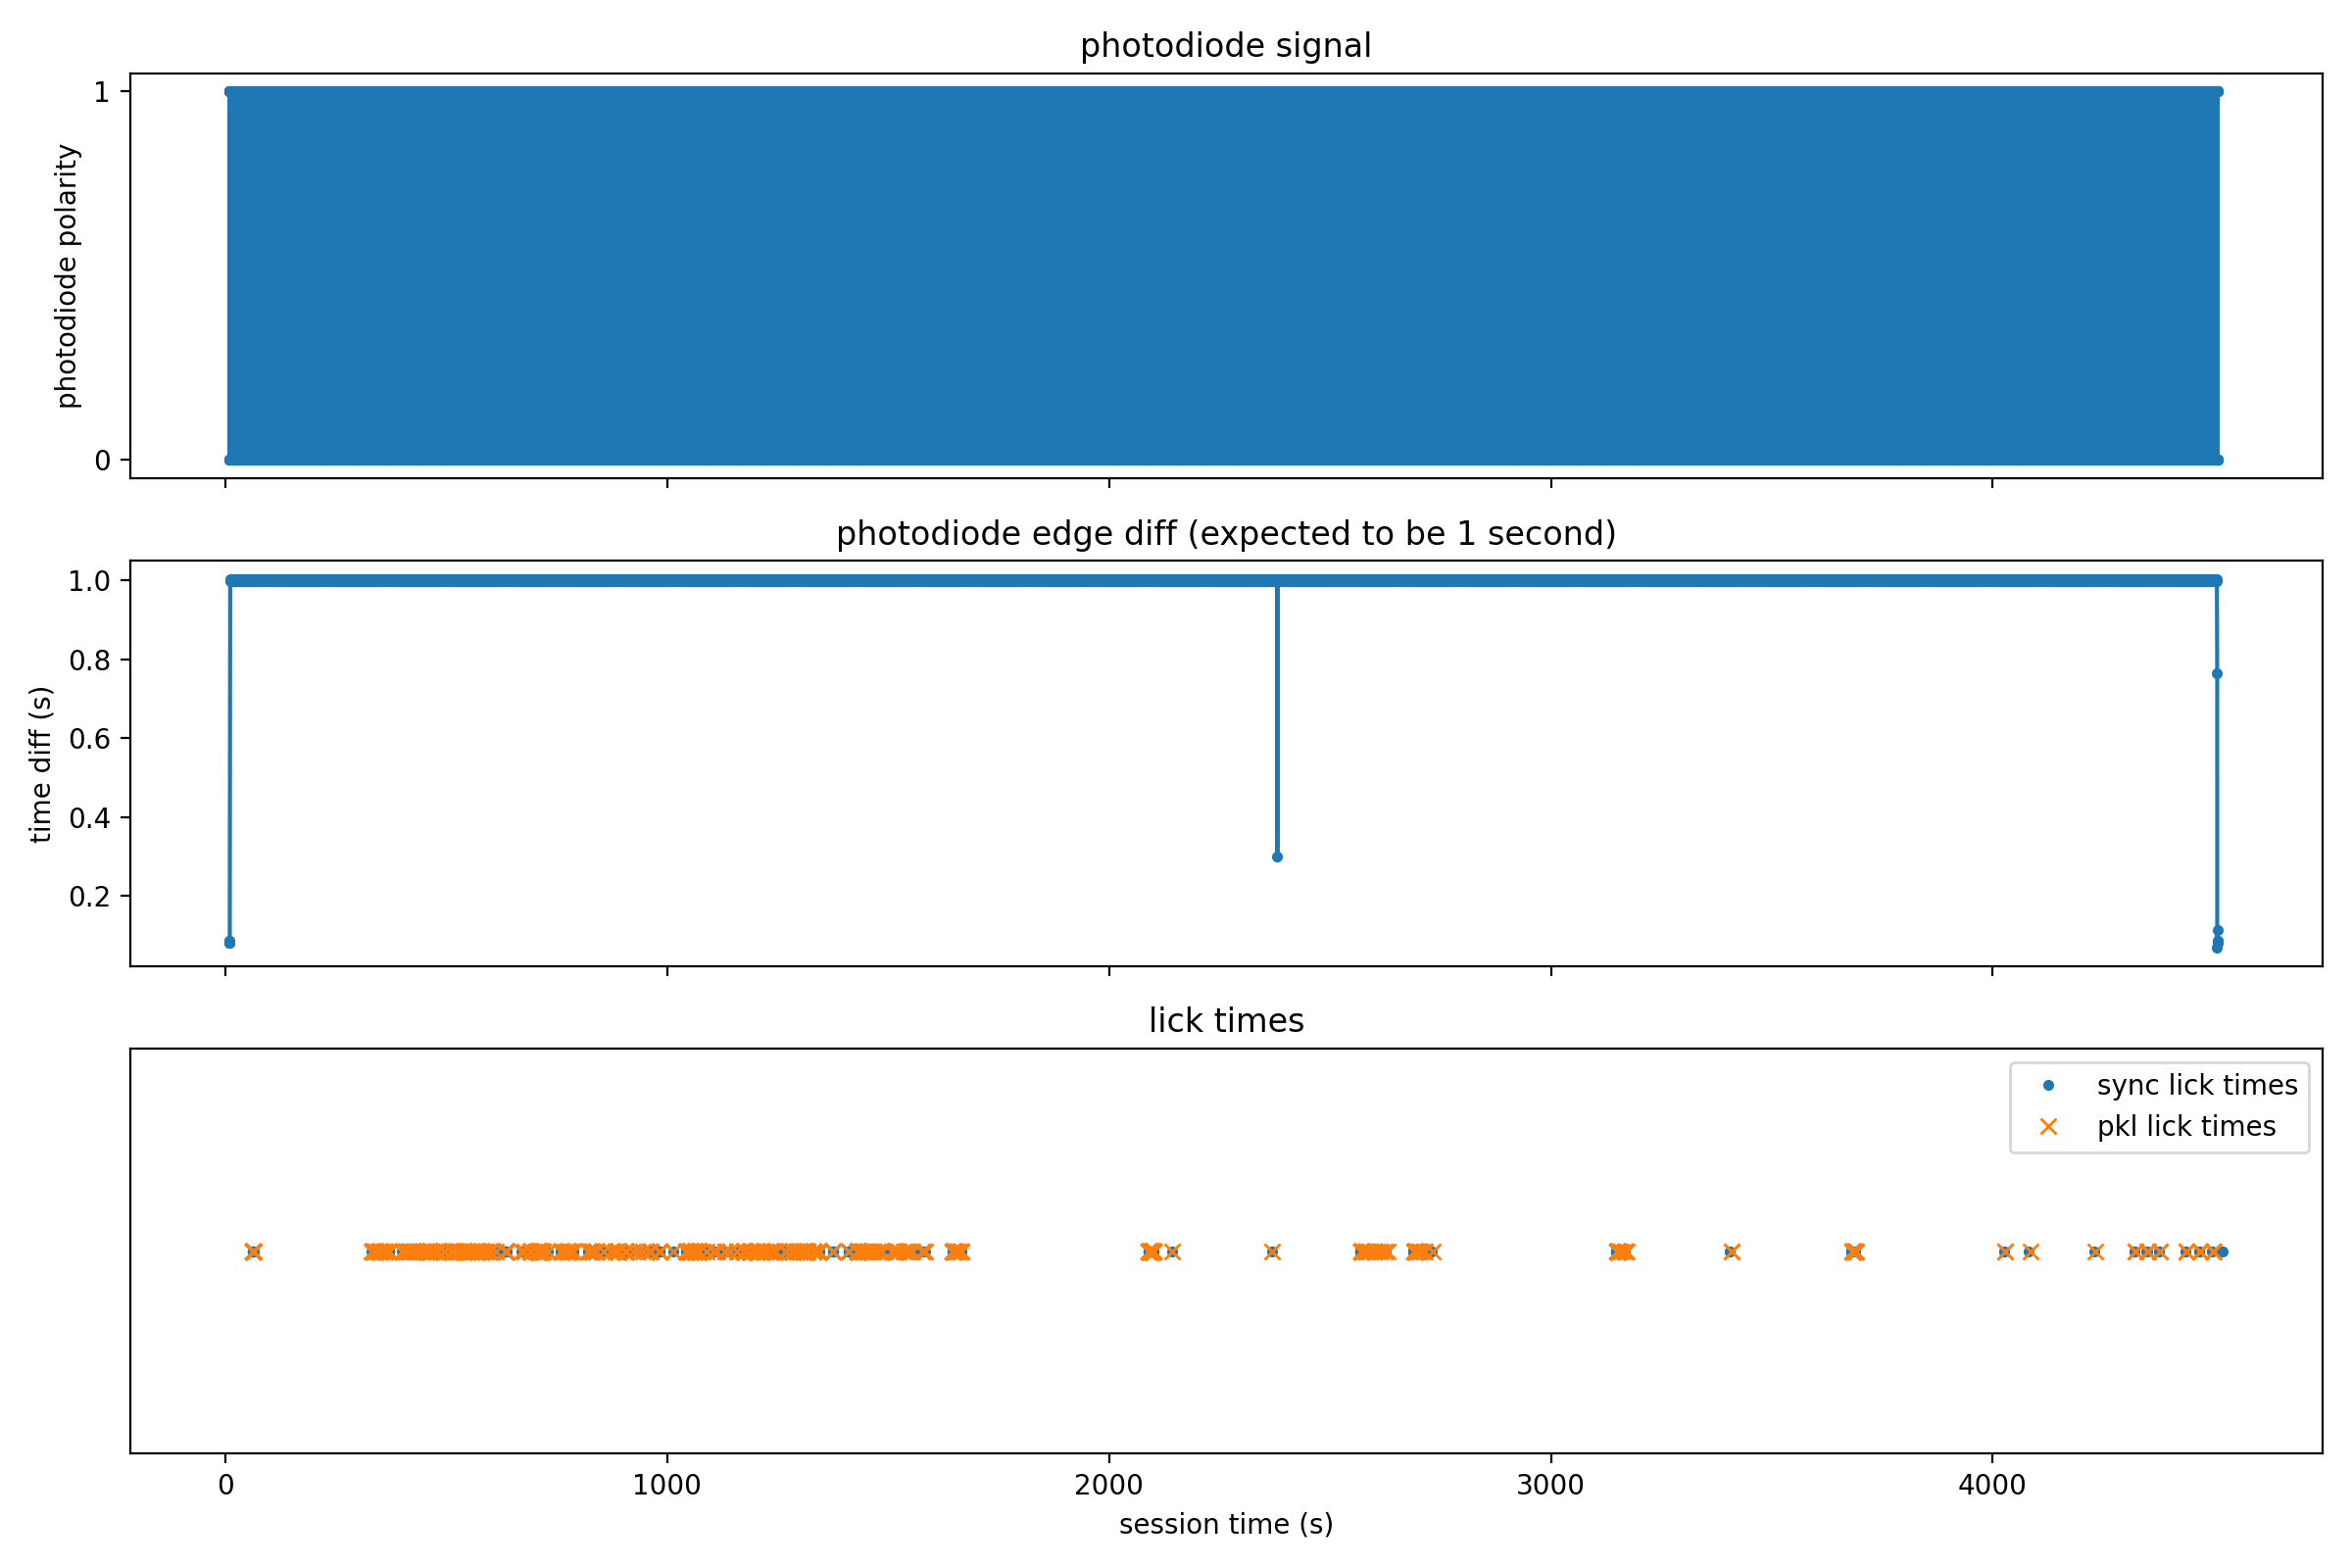

In [25]:
def make_plot():
    fig, ax = plt.subplots(3,1, figsize=(12,8), sharex=True)
    ax[0].plot(
        pd_combined['time'],
        pd_combined['value'],
        marker = '.'
    )
    ax[1].plot(
        photodiode_df['time'],
        photodiode_df['time'].diff(),
        marker = '.'
    )

    ax[2].plot(sync_data['lick_sensor_rising'], np.zeros_like(sync_data[sync_line]), marker='.', linestyle = 'none')
    ax[2].plot(core_data['licks']['sync_time'], np.zeros_like(core_data['licks']['sync_time']), marker='x', linestyle='none')
    ax[2].legend(['sync lick times','pkl lick times'], loc='upper right')

    ax[0].set_title('photodiode signal')
    ax[0].set_ylabel('photodiode polarity')
    ax[0].set_yticks([0,1])

    ax[1].set_title('photodiode edge diff (expected to be 1 second)')
    ax[1].set_ylabel('time diff (s)')

    ax[2].set_title('lick times')
    ax[2].set_yticks([])

    ax[2].set_xlabel('session time (s)')
    fig.tight_layout()
    
    return fig, ax

fig, ax = make_plot()

## some exploration of the sync file itself below (incomplete)

In [19]:
sd = sync_dataset.Dataset(sync_path)

In [20]:
sd.meta_data

{'total_samples': 453030000,
 'sampling_type': 'frequency',
 'timeouts': [],
 'start_time': '2019-09-12 15:42:41.876000',
 'ni_daq': {'device': 'Dev1',
  'event_bits': 32,
  'counter_bits': 32,
  'sample_rate': 100000.0,
  'counter_output_freq': 100000.0},
 'version': {'sync': 1.05, 'dataset': 1.04},
 'stop_time': '2019-09-12 16:58:14.997000',
 'line_labels': ['2p_vsync',
  '',
  'stim_vsync',
  '',
  'stim_photodiode',
  'acq_trigger',
  '',
  '',
  'cam1_exposure',
  'cam2_exposure',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  '',
  'lick_sensor']}

In [21]:
dir(sd)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_bit_to_line',
 '_line_to_bit',
 '_process_times',
 'analog_meta_data',
 'close',
 'dfile',
 'duty_cycle',
 'frequency',
 'get_all_bits',
 'get_all_events',
 'get_all_times',
 'get_analog_channel',
 'get_analog_meta',
 'get_bit',
 'get_bit_changes',
 'get_events_by_bit',
 'get_events_by_line',
 'get_falling_edges',
 'get_line',
 'get_line_changes',
 'get_nearest',
 'get_rising_edges',
 'line_labels',
 'line_stats',
 'load',
 'meta_data',
 'period',
 'plot_all',
 'plot_bit',
 'plot_bits',
 'plot_line',
 'plot_lines',
 'sample_freq',
 'stats',
 'times']

In [22]:
sd.line_stats('stim_photodiode')

{'line': 'stim_photodiode',
 'bit': 4,
 'total_data_points': 1472528,
 'total_events': 4508,
 'total_rising': 2254,
 'total_falling': 2254,
 'avg_period': 1.9979552531083482,
 'min_period': 0.16679,
 'max_period': 2.0017,
 'period_sd': 0.0,
 'avg_freq': 0.5005117098815077,
 'duty_cycle': 'fix me'}

In [23]:
sd.stats()

[{'line': 0,
  'bit': 0,
  'total_data_points': 1472528,
  'total_events': 386024,
  'total_rising': 193012,
  'total_falling': 193012,
  'avg_period': 0.023308518470545568,
  'min_period': 0.0233,
  'max_period': 0.02711,
  'period_sd': 0.0,
  'avg_freq': 42.90276970042848,
  'duty_cycle': 'fix me'},
 {'line': 2,
  'bit': 2,
  'total_data_points': 1472528,
  'total_events': 539407,
  'total_rising': 269704,
  'total_falling': 269703,
  'avg_period': 0.01668031534805081,
  'min_period': 0.00661,
  'max_period': 0.02684,
  'period_sd': 0.0,
  'avg_freq': 59.95090495197716,
  'duty_cycle': 'fix me'},
 {'line': 4,
  'bit': 4,
  'total_data_points': 1472528,
  'total_events': 4508,
  'total_rising': 2254,
  'total_falling': 2254,
  'avg_period': 1.9979552531083482,
  'min_period': 0.16679,
  'max_period': 2.0017,
  'period_sd': 0.0,
  'avg_freq': 0.5005117098815077,
  'duty_cycle': 'fix me'},
 {'line': 5,
  'bit': 5,
  'total_rising': 1,
  'total_falling': 1,
  'avg_freq': None,
  'duty_cy

In [24]:
reload(sync_dataset)
sd.plot_all(start_time=0, stop_time=20)

NameError: name 'reload' is not defined

In [ ]:
from importlib import reload